# Data Preparation & Initial EDA of Online Retail Data

This notebook is the first step in a deeper analysis of the [Lifetimes](https://github.com/CamDavidsonPilon/lifetimes) package.
The raw data (see below) is cleaned, transformed and used for EDA.

#### Data Source
- `data/raw/OnlineRetail.xlsx`: A transnational data set which contains all the transactions occurring between 01/12/2010 and 09/12/2011 for a UK-based and registered non-store online retail. Many customers of the company are wholesalers. 

#### Data Output
- `data/interim/clv_data.csv`: Cleaned version of the input data. Will later be as input for CLV calculations in nb 2.
- `data/interim/customer_data.csv`: DataFrame with aggregated Customer Data (for EDA and later analysis of CLV results in nb 3).

#### Changes
- 19-02-12: Start, finish notebook

---

### Import libraries, load data

In [1]:
# import libraries
import numpy as np
import pandas as pd
import datetime as dt

# visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(), sns.set_style('whitegrid')
color = 'rebeccapurple'
%matplotlib inline  

import cleaning_functions as clean
import EDA_functions as EDA

# display of all columns in df
from IPython.display import display
pd.options.display.max_columns = None

In [2]:
# load data
data = pd.read_excel("data/raw/OnlineRetail.xlsx")

## 1) Prepare Data for EDA

### Assess basic data structure

In [3]:
data.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
InvoiceNo      541909 non-null object
StockCode      541909 non-null object
Description    540455 non-null object
Quantity       541909 non-null int64
InvoiceDate    541909 non-null datetime64[ns]
UnitPrice      541909 non-null float64
CustomerID     406829 non-null float64
Country        541909 non-null object
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
# change dtype for customerID to object
clv_data = clean.change_dtypes(data.copy(), cols_to_object=['CustomerID'])

# normalize InvoiceDate to dates (remove time)
clv_data['InvoiceDate'] = clv_data['InvoiceDate'].dt.date

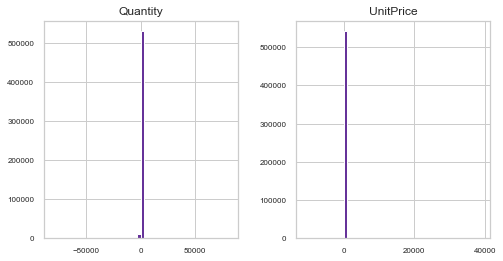

In [6]:
# check distribution of numerical data
EDA.plot_num_hist(clv_data, figsize=(8,4))

In [7]:
# check characteristics of numeric data
clv_data.describe()

,Quantity,UnitPrice
count,541909.000000,541909.000000
mean,9.552250,4.611114
std,218.081158,96.759853
min,-80995.000000,-11062.060000
25%,1.000000,1.250000
50%,3.000000,2.080000
75%,10.000000,4.130000
max,80995.000000,38970.000000


In [8]:
print("neg Quantities: ", len(clv_data.loc[clv_data['Quantity'] <= 0]))
print("neg unitPrices: ", len(clv_data.loc[clv_data['UnitPrice'] <= 0]))

neg Quantities:  10624
neg unitPrices:  2517


**Decision:** Orders with negative Quantities / UnitPrices will be dropped.

**Observations:**
- 90% of orders from UK
- 305 days with orders in period
- selling about 4000+ different products
- 4373 customers
- approx 25% of transactions without customerID
    

**Need for cleaning:**
- drop orders with quantities <= 0
- drop orders with unit_price <= 0
- drop orders with missing customer ID
- add new column sales (quant * price)
- re-change ID to dtype str
- drop cols we won't need no more: InvoiceNo, Description

### Clean Data for EDA

In [9]:
"""clean according to list"""

clv_data = clv_data.loc[clv_data['CustomerID'] != 'nan']
clv_data = clv_data.loc[clv_data['Quantity'] > 0]
clv_data = clv_data.loc[clv_data['UnitPrice'] > 0]
clv_data['CustomerID'] = clv_data['CustomerID'].astype(str).str.split('.').str.get(0)
clv_data['Sales'] = clv_data['Quantity'] * clv_data['UnitPrice']
clv_data.drop(['InvoiceNo', 'StockCode', 'Description'], inplace=True, axis=1)

assert clv_data.isnull().sum().sum() == 0, "NaN in the Set"

In [10]:
# check results
print(clv_data.shape)
display(clv_data.head())

(397884, 6)


,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,6,2010-12-01,2.55,17850,United Kingdom,15.30
1,6,2010-12-01,3.39,17850,United Kingdom,20.34
2,8,2010-12-01,2.75,17850,United Kingdom,22.00
3,6,2010-12-01,3.39,17850,United Kingdom,20.34
4,6,2010-12-01,3.39,17850,United Kingdom,20.34


In [11]:
"""make / load hardcopy"""

# # save a copy of prepared data
# clv_data.to_csv('data/interim/clv_data.csv', index=False)

# load prepared data
clv_data = pd.read_csv('data/interim/clv_data.csv', parse_dates=['InvoiceDate'],
                       dtype={'CustomerID' : str, 'Country' : 'category'})

### Customers: Create Dataframe with aggregated data

In [12]:
customers = clv_data.copy()
customers.set_index('CustomerID', inplace=True)
customers.head()

,Quantity,InvoiceDate,UnitPrice,Country,Sales
CustomerID,,,,,
17850,6,2010-12-01,2.55,United Kingdom,15.30
17850,6,2010-12-01,3.39,United Kingdom,20.34
17850,8,2010-12-01,2.75,United Kingdom,22.00
17850,6,2010-12-01,3.39,United Kingdom,20.34
17850,6,2010-12-01,3.39,United Kingdom,20.34


In [13]:
"""add recency / frequency metrics - according to lifetimes"""

# add min and max dates per customer as new columns
min_dates = customers.groupby(customers.index)['InvoiceDate'].min()
max_dates = customers.groupby(customers.index)['InvoiceDate'].max()
customers['first_date'] = min_dates
customers['last_date'] = max_dates

# add T (age), recency (first to last purchase) and frequency (number of repeat purchases)
customers['T'] = (np.datetime64('2011-12-09') - customers['first_date'])
customers['frequency'] = customers.groupby(customers.index)['InvoiceDate'].nunique() - 1
customers['recency'] = np.where((customers['frequency'] >= 1), \
                                (customers['last_date'] - customers['first_date']), 0)

customers['T'] = customers['T'].astype(str).str.split().str.get(0).astype(np.int64)
customers['recency'] = customers['recency'].astype(str).str.split().str.get(0).astype(np.int64)

In [14]:
# drop cols we don't need no more (NOTE: Sales is not summed, that's why we add it again later)
customers_data = pd.DataFrame(customers.groupby(customers.index).max())
customers_data.drop(['Quantity', 'InvoiceDate', 'UnitPrice', 'Sales'], axis=1, inplace=True)

In [15]:
""" add some additional metrics - NOTE: these are not according to liftimes """

# NOTE: lifetimes excludes sales of the first order
customers_data['Sales'] = customers.groupby(customers.index)['Sales'].sum() 
customers_data['avg_freq'] = np.where(customers_data['frequency'] >= 1, \
                (round(customers_data['recency'] / customers_data['frequency'],0)), 0)
customers_data['sleeping'] = (np.datetime64('2011-12-09') - customers_data['last_date'])
customers_data['sleeping'] = customers_data['sleeping'].astype(str).str.split().str.get(0).astype(np.int64)

In [16]:
#check results()
customers_data.head()

,first_date,last_date,T,frequency,recency,Sales,avg_freq,sleeping
CustomerID,,,,,,,,
12346,2011-01-18,2011-01-18,325,0,0,77183.60,0.0,325
12347,2010-12-07,2011-12-07,367,6,365,4310.00,61.0,2
12348,2010-12-16,2011-09-25,358,3,283,1797.24,94.0,75
12349,2011-11-21,2011-11-21,18,0,0,1757.55,0.0,18
12350,2011-02-02,2011-02-02,310,0,0,334.40,0.0,310


In [17]:
"""make / load hardcopy"""

# save a copy of cleaned data
customers_data.to_csv('data/interim/customers_data.csv')

# load cleaned data
customers_data = pd.read_csv('data/interim/customers_data.csv', index_col = 0,
                       parse_dates=['first_date', 'last_date'])

## 2) EDA

In [18]:
clv_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 397884 entries, 0 to 397883
Data columns (total 6 columns):
Quantity       397884 non-null int64
InvoiceDate    397884 non-null datetime64[ns]
UnitPrice      397884 non-null float64
CustomerID     397884 non-null object
Country        397884 non-null category
Sales          397884 non-null float64
dtypes: category(1), datetime64[ns](1), float64(2), int64(1), object(1)
memory usage: 15.6+ MB


### Outliers

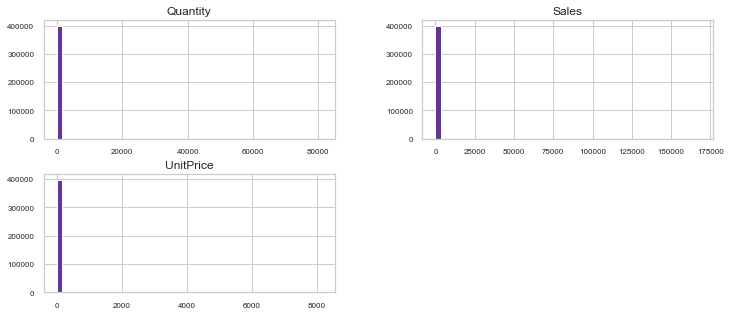

In [19]:
"""look for outliers"""

# re-check distribution of numerical data
EDA.plot_num_hist(clv_data, figsize=(12,5))

In [20]:
clv_data.sort_values(['UnitPrice'], ascending=False).head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
118341,1,2011-05-03,8142.75,16029,United Kingdom,8142.75
308796,1,2011-10-27,4161.06,12536,France,4161.06
308820,1,2011-10-27,4161.06,12536,France,4161.06
295229,1,2011-10-19,3949.32,12744,Singapore,3949.32
269568,1,2011-10-03,3155.95,15502,United Kingdom,3155.95


In [21]:
clv_data.sort_values(['Quantity'], ascending=False).head()

,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
397411,80995,2011-12-09,2.08,16446,United Kingdom,168469.60
37120,74215,2011-01-18,1.04,12346,United Kingdom,77183.60
308102,4800,2011-10-27,0.21,12901,United Kingdom,1008.00
143230,4300,2011-05-27,0.72,13135,United Kingdom,3096.00
61579,3906,2011-02-22,0.82,18087,United Kingdom,3202.92


**Decision:** Outliers will not (yet) be removed

### Period of Observation

In [22]:
print("Start date: ", clv_data['InvoiceDate'].dt.date.min())
print("End date: ", clv_data['InvoiceDate'].dt.date.max())

Start date:  2010-12-01
End date:  2011-12-09


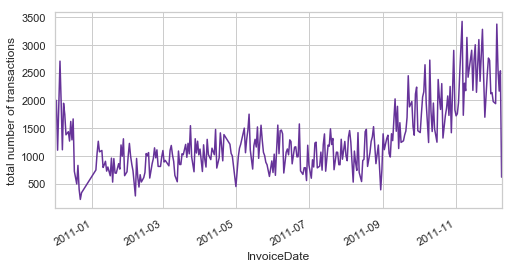

In [23]:
plt.figure(figsize=(8,4))
clv_data.groupby('InvoiceDate')['Country'].count().plot(color=color)
plt.ylabel('total number of transactions');

**Observation**: Either the increase from 2011-09 is from added customers, or the model could run into problems with the prediction ...

### Customers

In [24]:
customers_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4338 entries, 12346 to 18287
Data columns (total 8 columns):
first_date    4338 non-null datetime64[ns]
last_date     4338 non-null datetime64[ns]
T             4338 non-null int64
frequency     4338 non-null int64
recency       4338 non-null int64
Sales         4338 non-null float64
avg_freq      4338 non-null float64
sleeping      4338 non-null int64
dtypes: datetime64[ns](2), float64(2), int64(4)
memory usage: 305.0 KB


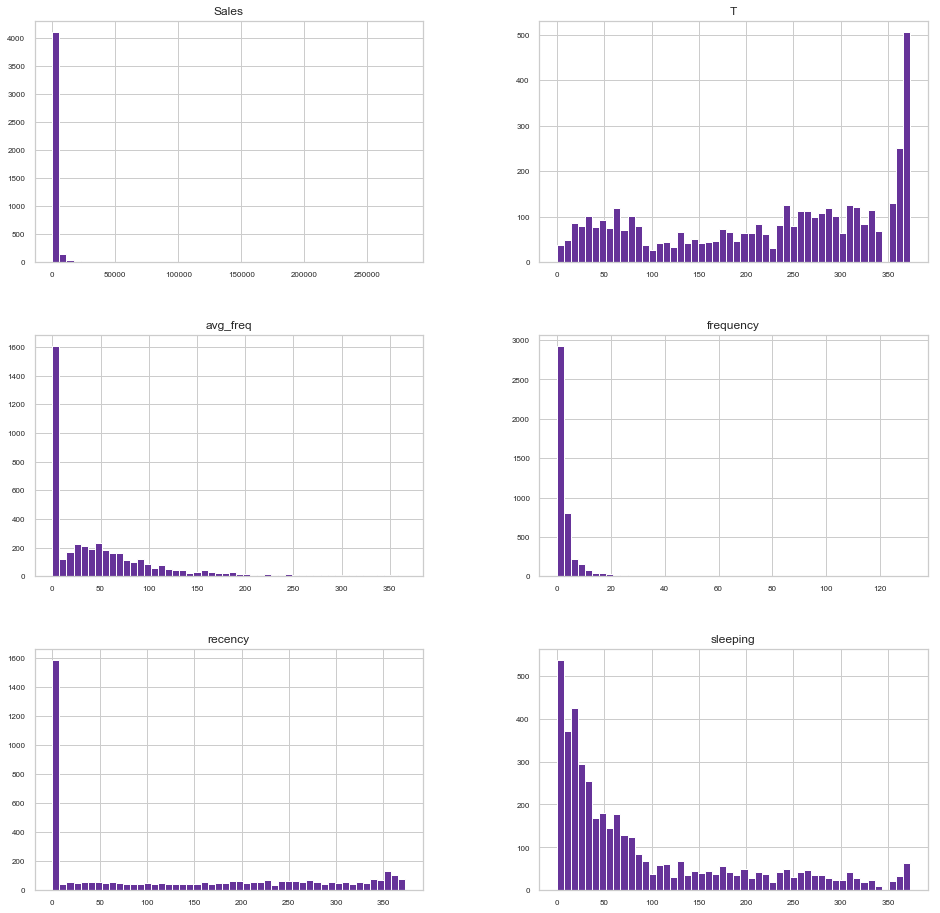

In [25]:
EDA.plot_num_hist(customers_data)

In [26]:
print("prop of customers without repeat purchase: ", \
      round(customers_data['frequency'].value_counts()[0]/len(customers_data),3))

prop of customers without repeat purchase:  0.357


**Observations:**
- T: a steady influx of customers. A peak at the very start of the period (high T), this can also be seen in the period plot.
- Frequency: highest share are 1 time buyers (ca. 35% of all)
- Recency: a result of the two, lot's of 0 (no repeat), the rest is distributed evenly
- avg_Freq: for those who buy repeated it is quite high, somewhere between 20 and 100 maybe
- Sleeping: right skewed, so probably the older clients are more often repeat buyer than the younger ones (?)

In [27]:
# stats for all customers
customers_data[['T', 'Sales', 'avg_freq', 'sleeping']].describe()

,T,Sales,avg_freq,sleeping
count,4338.000000,4338.000000,4338.000000,4338.000000
mean,222.831028,2054.266460,50.444675,92.059474
std,117.854570,8989.230441,65.241781,100.012264
min,0.000000,3.750000,0.000000,0.000000
25%,112.000000,307.415000,0.000000,17.000000
50%,248.000000,674.485000,31.000000,50.000000
75%,326.000000,1661.740000,73.000000,141.750000
max,373.000000,280206.020000,366.000000,373.000000


In [28]:
# stats for repeat buyers
customers_data.loc[customers_data['frequency'] != 0].describe()

,T,frequency,recency,Sales,avg_freq,sleeping
count,2790.000000,2790.000000,2790.000000,2790.000000,2790.000000,2790.000000
mean,260.120789,4.453405,203.328674,2941.457449,78.433333,56.792115
std,101.480175,6.924876,111.459556,10981.338571,66.505423,68.299126
min,9.000000,1.000000,1.000000,6.900000,1.000000,0.000000
25%,197.250000,1.000000,106.000000,628.912500,34.000000,10.000000
50%,284.000000,3.000000,211.000000,1192.930000,59.000000,29.000000
75%,358.000000,5.000000,301.750000,2474.305000,99.000000,73.000000
max,373.000000,131.000000,373.000000,280206.020000,366.000000,372.000000


**Observations (repeat buyers):**
- about 4 purchases on average
- about 60 days between purchases
- about 1200 in sales on median (roughly double to total)
- sleeping since 30-50 days on average / median (roughly half of total)

('first_date', 'rebeccapurple')
('last_date', 'yellow')


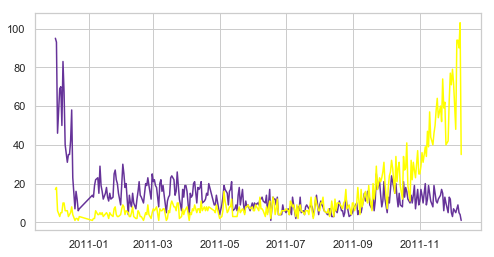

In [29]:
# visualize first and last events over time
customers_dt = customers_data.select_dtypes(include='datetime')
colors = [color, 'yellow']
leg = zip(customers_dt.columns, colors)
plt.figure(figsize=(8,4))

for i in leg:
    print(i)

for n, col in enumerate(customers_dt):
    customers_dt_grouped = customers_dt.groupby(col).count()
    plt.plot(customers_dt_grouped, color=colors[n]);

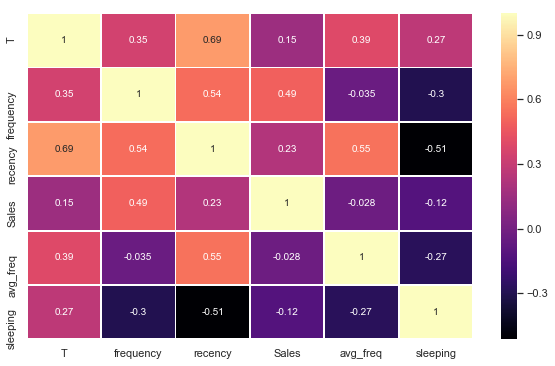

In [30]:
EDA.plot_num_corrMap(customers_data, figsize=(10,6))

### Purchases

All separate transactions for one customer in one day are considered one purchase.

In [51]:
purchases = pd.DataFrame(clv_data.groupby(['CustomerID', 'InvoiceDate']).sum())
purchases.drop(['Quantity', 'UnitPrice'], axis=1, inplace=True)

#check results
print("total number of purchases: ", purchases.shape[0])
display(purchases.head())

total number of purchases:  16763


Sales
CustomerID InvoiceDate          
12346      2011-01-18   77183.60
12347      2010-12-07     711.79
           2011-01-26     475.39
           2011-04-07     636.25
           2011-06-09     382.52

Mean transaction value:  531.6117582771581
Mean transaction value per customer:  458.1451031837687


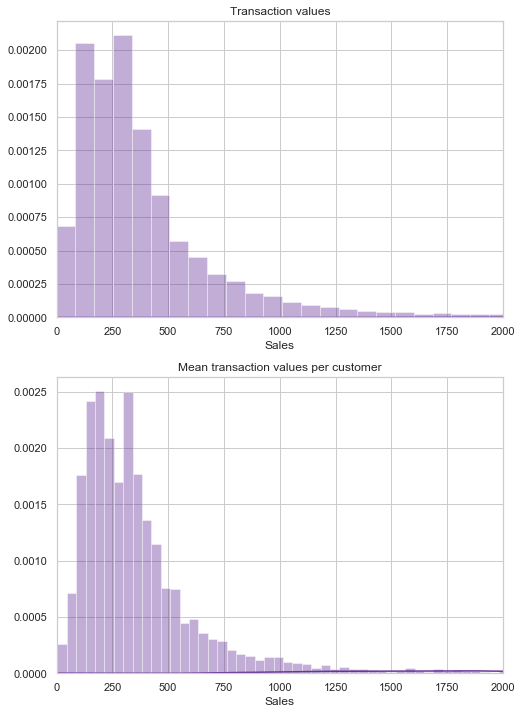

In [61]:
print("Mean transaction value: ",  np.mean(purchases['Sales'].values))
print("Mean transaction value per customer: ", np.mean(purchases.groupby(['CustomerID'])['Sales'].mean()))


plt.figure(figsize=(8,12))
plt.subplot(2,1,1)
sns.distplot(purchases['Sales'], color=color, bins=2000)
plt.xlim(0, 2000)
plt.title("Transaction values",  size=12);

plt.subplot(2,1,2)
sns.distplot(purchases.groupby(['CustomerID'])['Sales'].mean(), 
             color=color, 
             bins=2000
             )
plt.xlim(0, 2000)
plt.title("Mean transaction values per customer", size=12);

In [42]:
# count unique orders per day
purchases = purchases.unstack(level='CustomerID')
purchases['amount'] = purchases.count(axis=1)
purchases_day = purchases[['amount']] 

# check result
purchases_day.head()

,amount
CustomerID,
InvoiceDate,
2010-12-01,95
2010-12-02,99
2010-12-03,50
2010-12-05,75
2010-12-06,82


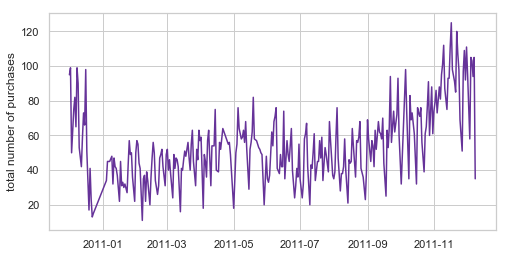

In [43]:
plt.figure(figsize=(8,4))
sns.lineplot(data=purchases['amount'], color=color)
plt.ylabel('total number of purchases');

**Observation:** Distribution is more or less the same as for the single transactions.

---